In [26]:
# Import libraries
from google.colab import drive
drive.mount('/content/drive')

import keras as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import pickle
import json
import time
from os import listdir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip file
!unzip Dataset3.zip

(2839, 4732, 3) (360, 360, 3)


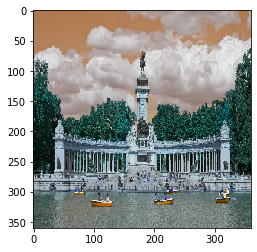

In [22]:
# Check if dataset is uploaded
path = './Dataset/alfonso_xii/alfonsoXII_1.jpg'
im = cv2.imread(path)
imres = cv2.resize(im,(360,360))
print(im.shape, imres.shape)
plt.figure()
plt.imshow(imres)

In [0]:
# Resizing images from Dataset to 256x256 pixels
def resizeDataset(path):
    resizedim = []
    for pc in glob.glob(f"./{path}/*/*"):     
        resizedim.append(cv2.resize(cv2.imread(pc), (256,256)))
    return np.asarray(resizedim)

X = resizeDataset('Dataset')

In [0]:
# Assigning numbers to classes and converting to categorical
def groundTruth(folder):
    path, dirs, files = next(os.walk(f"./{folder}"))
    GT=[]
    for pc in glob.glob(f"./{folder}/*/*"):
        for i in range(0,len(dirs)):
            if pc.split('/')[-2] == dirs[i]:
                GT.append(i)
    return np.asarray(GT)

y = groundTruth('Dataset')
y = tf.utils.to_categorical(
    y,
    num_classes=13,
    dtype='float32')

In [0]:
# Splitting data points to train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [43]:
num_classes = 13
img_rows, img_cols, img_colors = 256, 256, 3
input_shape = (img_rows, img_cols, img_colors)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1088, 256, 256, 3) (272, 256, 256, 3) (1088, 13) (272, 13)


In [0]:
# Neuronal network tipology

batch_size = 20
epochs = 5

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

model = Sequential()
chanDim = -1
if K.image_data_format() == "channels_first":
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adadelta(), metrics=["accuracy"])

In [0]:
# Save the model at the end of every epoch if val_accuracy is better 
filepath='Checkpoint_{epoch:02d}_{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [74]:
# Fit model
history = model.fit_generator(
    aug.flow(X_train, y_train, batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=X_train.shape[0],
    epochs=epochs, verbose=1,
    callbacks=callbacks_list
    )

Epoch 1/5
1088/1088 [==============================] - 355s 326ms/step - loss: 0.5543 - acc: 0.8388 - val_loss: 0.3376 - val_acc: 0.8971

Epoch 00001: val_acc improved from -inf to 0.89706, saving model to Checkpoint_01_0.90.hdf5
Epoch 2/5
1088/1088 [==============================] - 364s 335ms/step - loss: 0.1591 - acc: 0.9486 - val_loss: 0.3425 - val_acc: 0.9154

Epoch 00002: val_acc improved from 0.89706 to 0.91544, saving model to Checkpoint_02_0.92.hdf5
Epoch 3/5
1088/1088 [==============================] - 367s 337ms/step - loss: 0.0866 - acc: 0.9729 - val_loss: 0.2628 - val_acc: 0.9081

Epoch 00003: val_acc did not improve from 0.91544
Epoch 4/5
1088/1088 [==============================] - 360s 331ms/step - loss: 0.0562 - acc: 0.9816 - val_loss: 0.2470 - val_acc: 0.9265

Epoch 00004: val_acc improved from 0.91544 to 0.92647, saving model to Checkpoint_04_0.93.hdf5
Epoch 5/5
1088/1088 [==============================] - 356s 328ms/step - loss: 0.0409 - acc: 0.9865 - val_loss: 0.22

In [0]:
# save model as .h5
moment=time.localtime()
name='Model_{}_{}-{}-{}.h5'.format(model.history.history["val_acc"][-1],moment[2],moment[3],moment[4])
model.save(name)

In [0]:
# save model as .json
model_json = model.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(name)

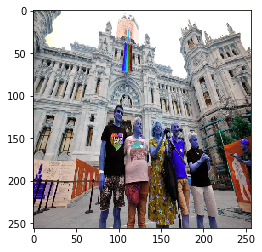

In [111]:
# Predicting for a new image from google
path = 'ayto.jpg'
im = cv2.imread(path)
imres1 = cv2.resize(im,(256,256))
pred = model.predict(np.expand_dims(imres1,axis=0))[0]
plt.imshow(Image.fromarray(imres1.squeeze()))

In [80]:
# Checking test loss and test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22147991414428414
Test accuracy: 0.9558823529411765


In [113]:
# Checking dirs and order of classes
path, dirs, files = next(os.walk("./Dataset"))
dirs_count = len(dirs)
dirs_count
print(dirs)

['atocha', 'alfonso_xii', 'museo_prado', 'schweppes', 'plaza_mayor', 'la_almudena', 'ayuntamiento', 'debod', 'puerta_alcala', 'ventas', 'banco_esp', 'jardin_botanico', 'palacio_cristal']


In [112]:
# Predicted!!!
for i, p in enumerate(pred):
    if p > 0.9:
        print(dirs[i], p)

ayuntamiento 0.9999541
